In [1]:
import gurobipy as gb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import random

plt.rcParams['font.size']=12
plt.rcParams['font.family']='serif'
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False  
plt.rcParams['axes.spines.bottom'] = True     
plt.rcParams["axes.grid"] = True
plt.rcParams['grid.linestyle'] = '-.' 
plt.rcParams['grid.linewidth'] = 0.4


In [2]:
with open('Data/ALL_scenarios_TESTING.json') as f:
    all_scenarios = json.load(f)

all_scenarios.keys()

OMEGA = 250 # number of scenarios to sample
PI = 1 / OMEGA # probability of each sampled scenario - assumed to be equal

S = len(all_scenarios.keys()) - 1 # number of total scenarios
T = 24 # number of hours

WIND_CAPACITY = 200 #MWh

random.seed(23)

# Sample scenarios without replacement
in_sample_scenarios = random.sample(range(S), OMEGA)

print(in_sample_scenarios)

scenarios = {}

# Extract sampled scenarios from dictionary containing all scenarios
for i in range(len(in_sample_scenarios)):
    scenarios[str(i)] = all_scenarios[str(in_sample_scenarios[i])]
    scenarios[str(i)]['Original Index'] = in_sample_scenarios[i]
    
print('Number of extracted scenarios:', len(scenarios))

# =============================================================================

average_SS = np.mean([scenarios[str(w)]['System Balance State'] for w in range(OMEGA)], axis=0)

# median wind across all scenarios
wind_median = np.median([scenarios[str(w)]['Wind Power [MW]'] for w in range(OMEGA)], axis=0)

print('\nAverage system states:')
print(average_SS)


[7576, 6384, 7770, 2374, 7310, 6796, 684, 139, 4849, 2512, 3471, 3106, 4342, 2933, 1067, 5947, 1572, 2190, 3641, 115, 1810, 5080, 3727, 7386, 202, 867, 702, 5816, 4081, 3450, 160, 4199, 5141, 6014, 3533, 2940, 6314, 471, 1684, 6415, 289, 4826, 3023, 5389, 1408, 5087, 1769, 7952, 6022, 2971, 4632, 6224, 7046, 3020, 7934, 4686, 2304, 5411, 7984, 2575, 4693, 6670, 3883, 1455, 5881, 3957, 4838, 6483, 3665, 5535, 5262, 1340, 1491, 6545, 1462, 4371, 2649, 5516, 6683, 4260, 1602, 4770, 936, 674, 807, 3490, 318, 4653, 2257, 7701, 4692, 2298, 6722, 4832, 2709, 893, 3028, 7373, 2363, 4441, 2496, 7328, 6369, 3725, 4497, 1788, 2116, 1224, 877, 5076, 6420, 978, 5792, 6513, 6787, 4038, 1949, 2689, 4468, 1166, 7526, 6105, 4855, 822, 7745, 3137, 1370, 3680, 7987, 276, 458, 5167, 3409, 3222, 191, 1331, 6631, 1848, 5629, 104, 7976, 1820, 6594, 6066, 7772, 465, 4412, 7738, 3646, 6135, 760, 2835, 130, 7982, 6457, 3088, 4018, 1583, 303, 621, 2165, 3817, 4491, 1610, 6184, 7647, 3760, 7786, 2421, 750, 847, 4

Define one-price scheme function

In [3]:
def solve_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA):
    direction = gb.GRB.MAXIMIZE #Min / Max

    m = gb.Model() # Create a Gurobi model  
    m.setParam('OutputFlag', 0)

    #============= Variables =============
    p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA") # day-ahead power bid
    delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta") # decision variable for the power imbalance - can be negative
    price_coeff = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="K") # price coefficient for the imbalance price wrt. the day-ahead price

    #============= Objective function =============
    # Set objective function - note that the day-ahead price is factored out of the sum
    obj = gb.quicksum(PI * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t,w] * delta[t,w]) for t in range(T) for w in range(OMEGA))
    m.setObjective(obj, direction)

    #============= Day-ahead power bid limits ============

    #Upper limit is the nominal wind power
    m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

    #============= Power imbalance definition (realized - bid) ===============
    m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))

    #============= Price coefficient definition ===============
    # the system balance parameter is 0 if the system has a surplus and 1 if it has a deficit
    m.addConstrs(price_coeff[t,w] == 1.2 * scenarios[str(w)]['System Balance State'][t] + 0.9 * (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

    #============= Display and run model =============
    m.update()
    #m.display()
    m.optimize()

    #============= Results =============
    results = {}
    if m.status == gb.GRB.OPTIMAL:
        #initialization
        for scenario in range(OMEGA):
            df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]', 'Imbalance [MW]', 'DA Profit [EUR]', 'Balancing Profit [EUR]', 'System State', 'Balancing Price Coefficient'])
            
            for t in range(T):
                df.loc[t] = [t, 
                            scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t], 
                            scenarios[str(scenario)]['Wind Power [MW]'][t], p_DA[t].x, 
                            delta[t,scenario].x, scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x, 
                            price_coeff[t,scenario].x * scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * delta[t,scenario].x, 
                            scenarios[str(scenario)]['System Balance State'][t], price_coeff[t,scenario].x]
            df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

            df['Hour'] = df['Hour'].astype(int)
            df['System State'] = df['System State'].astype(int)
            df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
            df.set_index('Hour', inplace=True)
            results[scenario] = df.copy(deep=True)

        print('-----------------------------------------------')
        print('Objective value (expected profit): %.2f EUR' % m.objVal)
        print('-----------------------------------------------')
        print('Day-ahead bids:')
        average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

        summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]', 'Median Wind [MW]', 'Average System State', 'Average Price Coefficient'])
        for t in range(T):
            summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]), np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]), np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)]), np.mean([price_coeff[t,w].x for w in range(OMEGA)])]

        summary['Hour'] = summary['Hour'].astype(int)
        summary.set_index('Hour', inplace=True)

        results['Summary'] = summary.copy(deep=True)

        for t in range(T):
            print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

        print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
        print('-----------------------------------------------')
        print('Runtime: %f ms' % (m.Runtime * 1e3))
        print('Number of variables: %d' % m.NumVars)
        print('Number of constraints: %d' % m.NumConstrs)
        return p_DA, results
    else:
        print("Optimization was not successful.")
        return None, None    


Run one-price for the sample without any risk parameters

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-28
-----------------------------------------------
Objective value (expected profit): 179311.38 EUR
-----------------------------------------------
Day-ahead bids:
Hour 0 | Bid: 0.00 MW | Average Profit: 6021.00 EUR
Hour 1 | Bid: 0.00 MW | Average Profit: 6067.61 EUR
Hour 2 | Bid: 0.00 MW | Average Profit: 5661.34 EUR
Hour 3 | Bid: 0.00 MW | Average Profit: 5416.53 EUR
Hour 4 | Bid: 200.00 MW | Average Profit: 5267.37 EUR
Hour 5 | Bid: 0.00 MW | Average Profit: 5697.62 EUR
Hour 6 | Bid: 0.00 MW | Average Profit: 6532.16 EUR
Hour 7 | Bid: 0.00 MW | Average Profit: 7116.64 EUR
Hour 8 | Bid: 0.00 MW | Average Profit: 8033.80 EUR
Hour 9 | Bid: 200.00 MW | Average Profit: 8020.92 EUR
Hour 10 | Bid: 0.00 MW | Average Profit: 8579.27 EUR
Hour 11 | Bid: 0.00 MW | Average Profit: 8540.40 EUR
Hour 12 | Bid: 0.00 MW | Average Profit: 8625.85 EUR
Hour 13 | Bid: 0.00 MW | Average Profit: 8413.09 EUR
Hour 14 | Bi

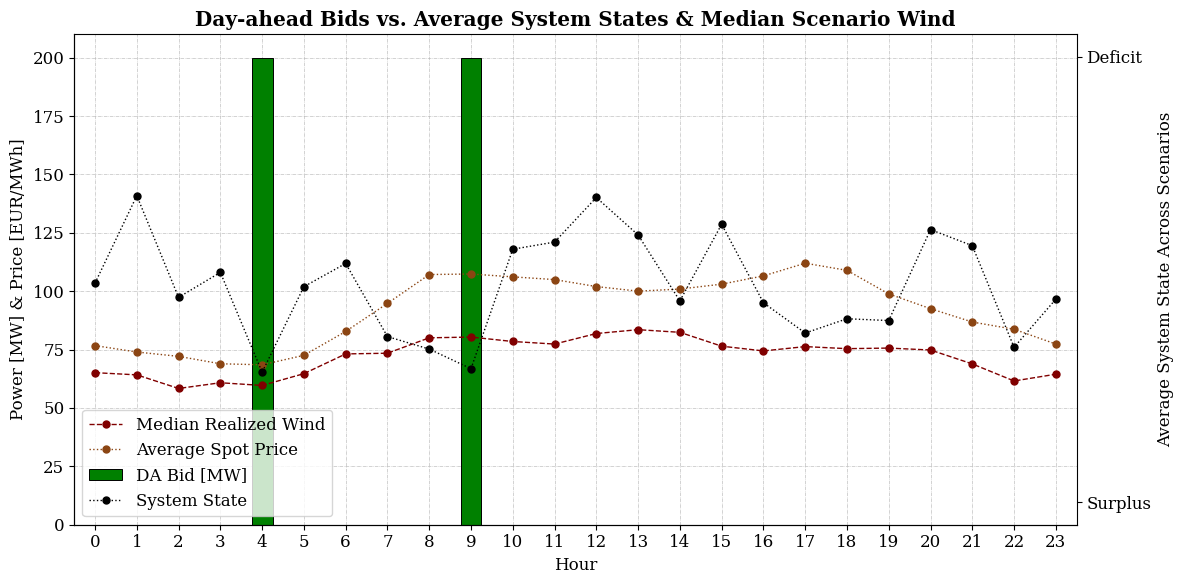

In [4]:
p_DA_op, results_op = solve_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA)

fig = plt.figure(figsize=(12, 6))
ax1 = fig.gca()

#plot day-ahead bid for each hour
results_op['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax1, label='Day-ahead bid', color='green', edgecolor='black', linewidth=0.7, align='center', width=0.5)
ax1.set_xlabel('Hour')
ax1.set_ylabel('Power [MW] & Price [EUR/MWh]')

#plot average "system state" for each hour
average_system_state = np.mean([scenarios[str(w)]['System Balance State'] for w in range(OMEGA)], axis=0)

#create twinx
ax2 = ax1.twinx()

ax2.plot(average_system_state, color='black', linewidth=1, label='System State', marker='o', markersize=5, linestyle=':')

#plot median realized wind power across scenarios as black line
ax1.plot(results_op['Summary']['Median Wind [MW]'], color='maroon', linewidth=1, marker='o', markersize=5,linestyle='--', label='Median Realized Wind')

ax1.set_ylim([0, 1.05 * WIND_CAPACITY])

#plot average spot price
average_spot_price = np.mean([scenarios[str(w)]['Spot Price [EUR/MWh]'] for w in range(OMEGA)], axis=0)

ax1.plot(average_spot_price, color='saddlebrown', linewidth=1, label='Average Spot Price', marker='o', markersize=5, linestyle=':')

# ask matplotlib for the plotted objects and their labels
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='lower left')

# formatting
ax1.set_title('Day-ahead Bids vs. Average System States & Median Scenario Wind', weight='bold')
ax1.set_axisbelow(True)
ax2.grid(False)

ax1.set_xticklabels(ax1.get_xticklabels(), rotation=0)

ax2.set_ylim([-0.05,1.05])
ax2.set_yticks([0,1])
ax2.set_yticklabels(['Surplus', 'Deficit'])

ax2.set_ylabel('Average System State Across Scenarios')

ax2.spines[['top','right']].set_visible(True)

fig.tight_layout()
plt.show()


### One-price Scheme **(with risk awareness)**

In [5]:
alpha = 0.9
beta_values = np.arange(0,1 + 0.1, 0.1)

Define function with risk awareness

In [6]:
def cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values, minimize_printouts=False, mip_gap = 1e-4):
    results_per_beta = {}
    p_DA_values_per_beta = {}
    
    for beta in beta_values:

        print('===============================================')
        print('Solving for beta = %.2f...' % beta)

        direction = gb.GRB.MAXIMIZE #Min / Max

        m = gb.Model() # Create a Gurobi model  

        m.setParam('OutputFlag', 0)
        
        if not mip_gap == 1e-4: m.setParam('MIPGap', mip_gap) #gurobi default is 1e-4

        #============= Variables =============
        p_DA = m.addVars(T, lb=0, ub=gb.GRB.INFINITY, name="p_DA")  # day-ahead power bid
        delta = m.addVars(T, OMEGA, lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="delta")  # power imbalance
        price_coeff = m.addVars(T, OMEGA, lb=0, ub=gb.GRB.INFINITY, name="K") # price coefficient for the imbalance price wrt. the day-ahead price
        eta = m.addVars(OMEGA, lb=0, ub=gb.GRB.INFINITY, name="n")  # auxiliary variable for risk-averse term
        zeta = m.addVar(lb=-gb.GRB.INFINITY, ub=gb.GRB.INFINITY, name="zeta")  # VaR variable for risk-averse term

        #============= Objective function =============
        # Define objective function
        expected_value = gb.quicksum(PI * scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t,w] * delta[t,w])
                                    for t in range(T) for w in range(OMEGA))
        
        cvar = zeta - (1 / (1 - alpha)) * gb.quicksum(PI * eta[w] for w in range(OMEGA))

        obj = (1 - beta) * expected_value + beta * cvar

        m.setObjective(obj, direction)

        #============= Constraints =============
        # Day-ahead power bid limits
        #Upper limit is the nominal wind power
        m.addConstrs(p_DA[t] <= WIND_CAPACITY for t in range(T))

        #============= Power imbalance definition (realized - bid) ===============
        m.addConstrs(delta[t,w] == scenarios[str(w)]['Wind Power [MW]'][t] - p_DA[t] for t in range(T) for w in range(OMEGA))

        #============= Price coefficient definition ===============
        # the system balance parameter is 0 if the system has a surplus and 1 if it has a deficit
        m.addConstrs(price_coeff[t,w] == 1.2 * scenarios[str(w)]['System Balance State'][t] + 0.9 * (1 - scenarios[str(w)]['System Balance State'][t]) for t in range(T) for w in range(OMEGA))

        #============= Conditional value at risk (CVaR) constraints ===============
        m.addConstrs(-gb.quicksum(
            scenarios[str(w)]['Spot Price [EUR/MWh]'][t] * (p_DA[t] + price_coeff[t,w] * delta[t,w])
            for t in range(T)) + zeta - eta[w] <= 0 for w in range(OMEGA))
        
        m.addConstrs(eta[w] >= 0 for w in range(OMEGA))

        #============= Display and run model =============
        m.update()
        m.optimize()

        #============= Results =============
        results = {}
        if m.status == gb.GRB.OPTIMAL:
            # Initialization
            for scenario in range(OMEGA):
                df = pd.DataFrame(columns=['Hour', 'DA Price [EUR/MWh]', 'Wind Power [MW]', 'DA Bid [MW]',
                                        'Imbalance [MW]', 'DA Profit [EUR]', 'Balancing Profit [EUR]',
                                        'System State', 'Balancing Price Coefficient'])
                for t in range(T):
                    df.loc[t] = [t,
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t],
                                scenarios[str(scenario)]['Wind Power [MW]'][t],
                                p_DA[t].x,
                                delta[t, scenario].x,
                                scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] * p_DA[t].x,
                                (scenarios[str(scenario)]['Spot Price [EUR/MWh]'][t] *
                                price_coeff[t, scenario].x *
                                delta[t, scenario].x),
                                scenarios[str(scenario)]['System Balance State'][t],
                                price_coeff[t, scenario].x]
                df['Total Profit [EUR]'] = df['DA Profit [EUR]'] + df['Balancing Profit [EUR]']

                df['Hour'] = df['Hour'].astype(int)
                df['System State'] = df['System State'].astype(int)
                df['System State'] = df['System State'].apply(lambda x: 'Deficit' if x == 1 else 'Surplus')
                df.set_index('Hour', inplace=True)
                results[scenario] = df.copy(deep=True)

                eta_values = [eta[w].x for w in range(OMEGA)]
                delta_values = [delta[t, w].x for t in range(T) for w in range(OMEGA)]
                price_coeff_values = [price_coeff[t, w].x for t in range(T) for w in range(OMEGA)]

                #Get CVaR, VaR, and expected profit  
                cvar_value = cvar.getValue()
                results['Expected Profit'] = expected_value.getValue()
                results['CVaR'] = cvar_value
                results['VaR'] = zeta.x
                p_DA_values = [p_DA[t].x for t in range(T)]

            print('-----------------------------------------------')
            print('Objective value: %.2f EUR' % m.objVal)
            print('Expected Profit: %.2f EUR' % results['Expected Profit'])
            print('CVaR: %.10f EUR' % results['CVaR'])
            print('VaR: %.2f EUR' % results['VaR'])
            print('Eta values:', eta_values)
            #print('Delta values:', delta_values)
            #print('Price coefficient values:', price_coeff_values)
            
            if not minimize_printouts:
                print('-----------------------------------------------')
                print('Day-ahead bids:')

            average_hourly_profit = np.mean([results[w]['Total Profit [EUR]'] for w in range(OMEGA)], axis=0)

            summary = pd.DataFrame(columns=['Hour', 'DA Bid [MW]', 'Average Profit [EUR]', 'Average Wind [MW]',
                                            'Median Wind [MW]', 'Average System State', 'Average Price Coefficient'])
            for t in range(T):
                summary.loc[t] = [t, p_DA[t].x, np.mean(average_hourly_profit[t]),
                                np.mean([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                np.median([results[w]['Wind Power [MW]'][t] for w in range(OMEGA)]),
                                np.mean([scenarios[str(w)]['System Balance State'][t] for w in range(OMEGA)]),
                                np.mean([price_coeff[t, w].x for w in range(OMEGA)])]

            summary['Hour'] = summary['Hour'].astype(int)
            summary.set_index('Hour', inplace=True)

            results['Summary'] = summary.copy(deep=True)

            if not minimize_printouts:
                for t in range(T):
                    print('Hour %d | Bid: %.2f MW | Average Profit: %.2f EUR' % (t, p_DA[t].x, average_hourly_profit[t]))

                print('Sum of average profits: %.2f EUR' % np.sum(average_hourly_profit))
                print('-----------------------------------------------')
                print('Runtime: %f ms' % (m.Runtime * 1e3))

            # Save results for this beta
            p_DA_values_per_beta[beta] = p_DA_values
            results_per_beta[beta] = results

        else:
            print("Optimization was not successful.")
    return results_per_beta,p_DA_values_per_beta

Run for each beta

In [7]:
results_per_beta_op, p_DA_values_per_beta_op = cvr_op_scheme(scenarios, WIND_CAPACITY, T, OMEGA, alpha, beta_values, minimize_printouts=True)
#results_per_beta_op[0]['Summary'].round(2)

Solving for beta = 0.00...
-----------------------------------------------
Objective value: 179311.38 EUR
Expected Profit: 179311.38 EUR
CVaR: -118152279.1442904770 EUR
VaR: 34733.02 EUR
Eta values: [8376225.957005167, 8419350.497280624, 8460690.599915152, 8502688.551019587, 16846640.883369386, 8359300.4660373395, 8437829.349017393, 17025664.073500574, 16896768.833032403, 16913665.534624495, 16814503.76859655, 8398562.630118536, 8502755.25479509, 16922097.64176131, 16937969.971133098, 8454440.0816935, 8464729.81225005, 8491740.752556127, 16869224.72153437, 16929696.284204453, 8447839.80131434, 8457330.564148065, 16751269.720792832, 8448681.35653629, 8532835.768277789, 16943678.849279057, 8522779.287284575, 8424171.193772074, 16922025.259732313, 8452966.774646, 8523644.897502271, 8442141.530007439, 8484975.087610418, 16705043.059265327, 8432702.65371355, 8463887.717306988, 8481492.957337791, 16948571.246800523, 16813704.46984691, 16680199.89700142, 8501203.485425398, 16815918.153757263,

Plot results per beta for the appendix

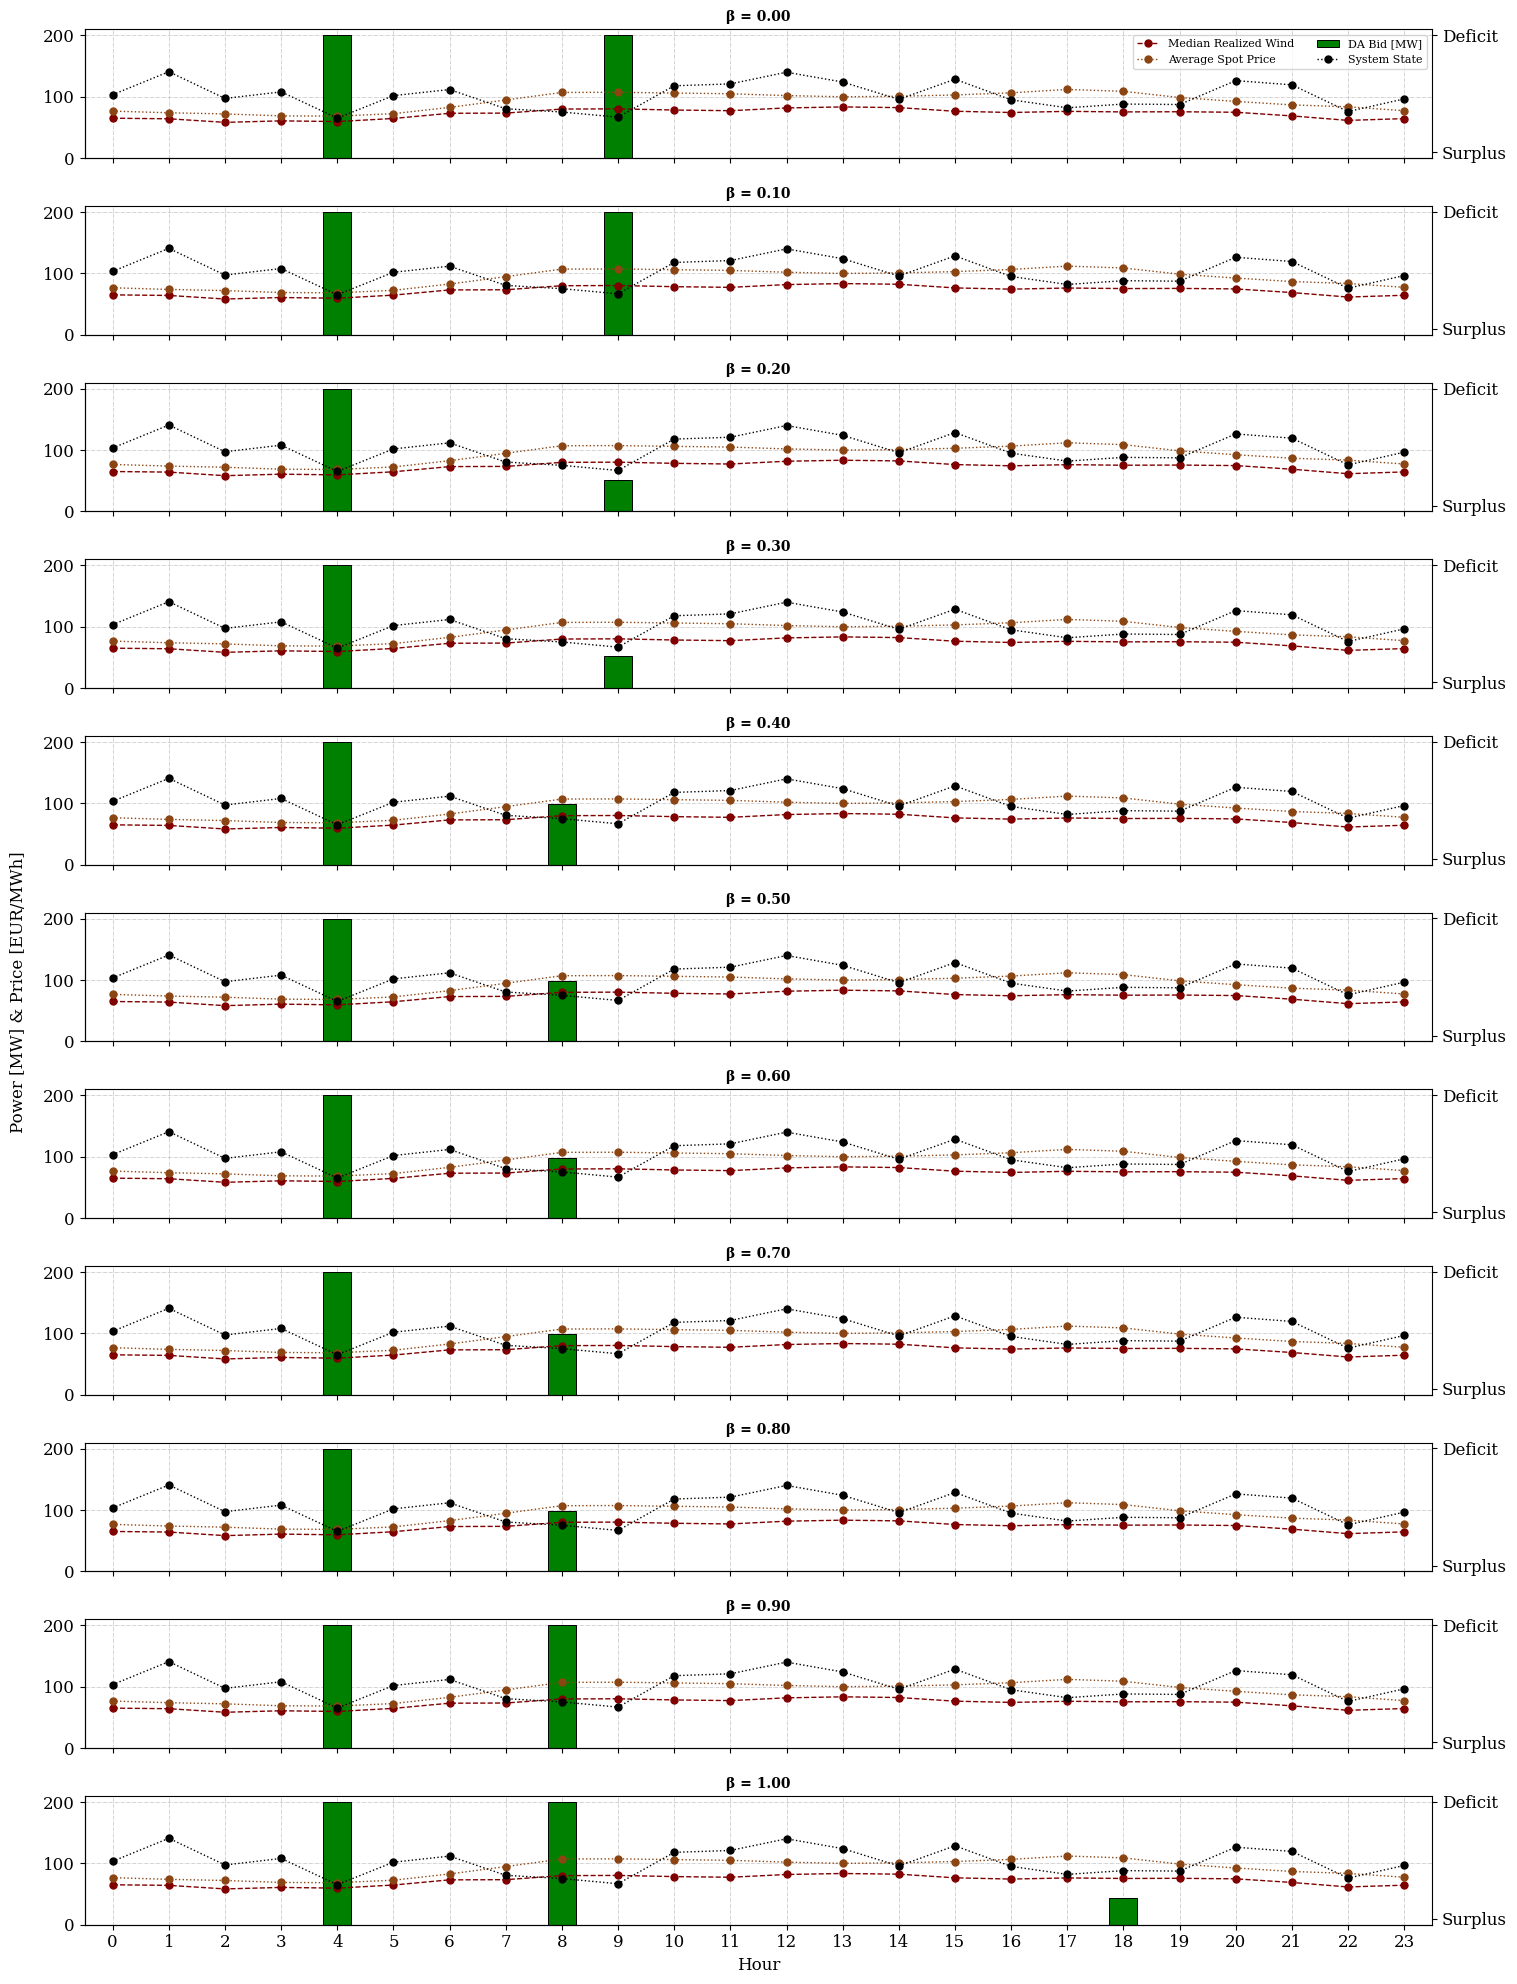

In [127]:
fig,ax = plt.subplots(len(beta_values),figsize=(15, 20), sharex=True)

average_spot_price = np.mean([scenarios[str(w)]['Spot Price [EUR/MWh]'] for w in range(OMEGA)], axis=0)
average_system_state = np.mean([scenarios[str(w)]['System Balance State'] for w in range(OMEGA)], axis=0)

n = 0
for beta in beta_values:
    #plot day-ahead bid for each hour
    if n == 0: leg = True
    else: leg = False
    results_per_beta_op[beta]['Summary']['DA Bid [MW]'].to_frame().plot.bar(ax = ax[n], label='Day-ahead bid', color='green', edgecolor='black', linewidth=0.7, align='center', width=0.5, legend=leg)
    #plot median realized wind power across scenarios as black line
    ax[n].plot(results_per_beta_op[0]['Summary']['Median Wind [MW]'], color='maroon', linewidth=1, marker='o', markersize=5,linestyle='--', label='Median Realized Wind')
    ax[n].plot(average_spot_price, color='saddlebrown', linewidth=1, label='Average Spot Price', marker='o', markersize=5, linestyle=':')

    #create twinx
    ax_temp = ax[n].twinx()
    ax_temp.plot(average_system_state, color='black', linewidth=1, label='System State', marker='o', markersize=5, linestyle=':')
    ax_temp.grid(False)
    ax_temp.set_ylim([-0.05,1.05])
    ax_temp.set_yticks([0,1])
    ax_temp.set_yticklabels(['Surplus', 'Deficit'])


    #Formatting
    ax[n].set_title('\u03B2 = %.2f' % beta, weight='bold', fontsize=10)
    ax[n].set_axisbelow(True)
    ax[n].set_ylim([0, 1.05 * WIND_CAPACITY])
    ax[n].spines[['top','right']].set_visible(True)

    n += 1

ax[-1].set_xlabel('Hour')
ax[-1].set_xticklabels(ax1.get_xticklabels(), rotation=0)


# ask matplotlib for the plotted objects and their labels
lines, labels = ax[0].get_legend_handles_labels()
lines2, labels2 = ax_temp.get_legend_handles_labels()
ax[0].legend(lines + lines2, labels + labels2, loc='upper right', fontsize=8, ncol=2)



fig.text(-0.01, 0.5,'Power [MW] & Price [EUR/MWh]', va='center', rotation='vertical')




fig.tight_layout()
#plt.savefig('Figures/Task_1C_Appendix_schedule_per_beta.png', dpi=300, bbox_inches='tight')
plt.show()

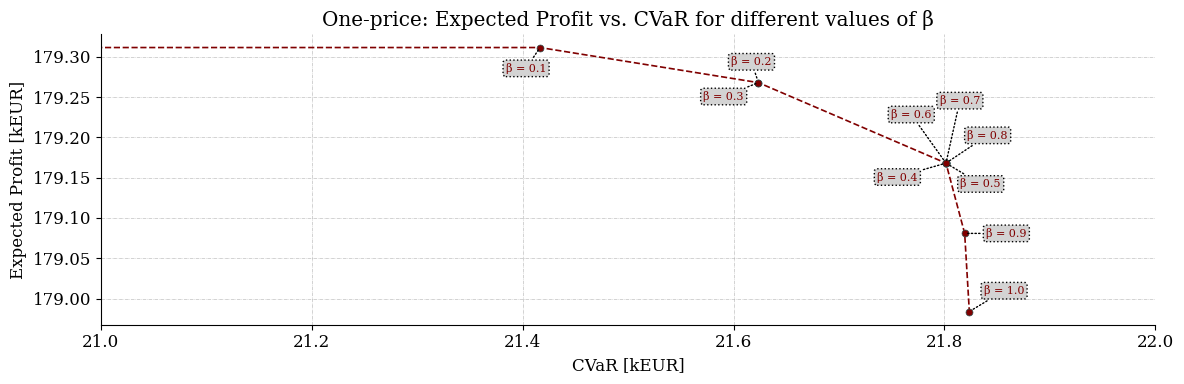

In [8]:
# Plot expected value vs. CVaR for different beta values
fig = plt.figure(figsize=(12, 4))

ax = fig.gca()
betas = list(results_per_beta_op.keys())
expected_profit = [results_per_beta_op[beta]['Expected Profit'] / 1e3 for beta in betas]
cvar_values = [results_per_beta_op[beta]['CVaR'] / 1e3 for beta in betas]


# # Adjust bbox and arrowprops as needed
arrowprops = dict(linestyle="dotted", arrowstyle='-', color='black', alpha=1)
bbox_props = dict(boxstyle="round,pad=0.25", fc="lightgrey", ec="black", lw=1, linestyle=':', alpha=1)

offsets = [(25,-15),   # 0.0
           (-10,-15),  # 0.1
           (-5,15),   # 0.2
           (-25,-10), # 0.3
           (-35,-10), # 0.4
           (25,-15),  # 0.5
           (-25, 35), # 0.6
           (10, 45),   # 0.7
           (30,20),   # 0.8
           (30,0),    # 0.9
           (25,15)]  # 1.0


for i in range(1, len(betas)):
    label = '\u03B2 = %.1f' % betas[i]
    xy = (cvar_values[i], expected_profit[i])

    ax.annotate(label, 
                    xy=xy, 
                    xytext=offsets[i], 
                    xycoords='data', 
                    textcoords='offset points', 
                    arrowprops=arrowprops,
                    bbox=bbox_props,
                    fontsize=8,
                    color='maroon',
                    ha = 'center',
                    va = 'center',
                    rotation=0,
                    clip_on=False,
                    annotation_clip=False)


plt.plot(cvar_values, expected_profit, marker='o', linestyle='--', color='maroon', markersize=5, markeredgecolor='darkslategray', markeredgewidth=0.5, linewidth=1.2)
plt.xlabel('CVaR [kEUR]')
plt.ylabel('Expected Profit [kEUR]')

plt.xlim([21000 / 1e3,22000 / 1e3])

plt.title('One-price: Expected Profit vs. CVaR for different values of \u03B2')

#plt.savefig('Figures/Task_1C_Appendix_CVaR_vs_Profit.png', dpi=300, bbox_inches='tight')

plt.tight_layout()
plt.show()


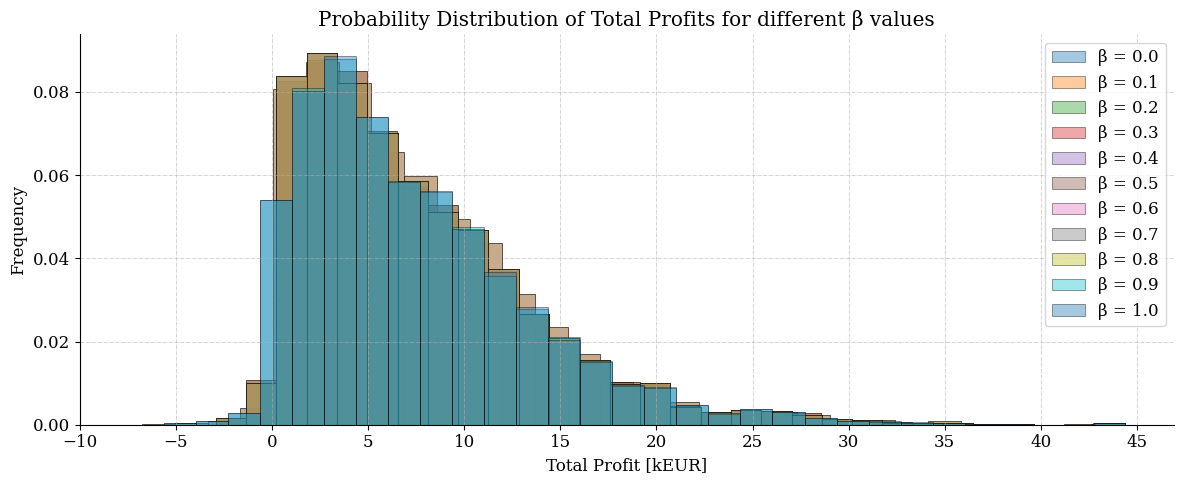

In [9]:
# Collect total profits for all scenarios for each beta
all_scenario_profits_per_beta = {beta: [] for beta in beta_values}
for beta, result in results_per_beta_op.items():
    for w in range(OMEGA):
        all_scenario_profits_per_beta[beta].extend(result[w]['Total Profit [EUR]'])

# Plot the probability distribution of profits for all scenarios for each beta
fig = plt.figure(figsize=(12, 5))
for beta, profits in all_scenario_profits_per_beta.items():
    plt.hist(np.array(profits)*1e-3, bins=30, density=True, alpha=0.4, label=f'\u03B2 = {beta.round(1)}', edgecolor='black', linewidth=0.7)
plt.title('Probability Distribution of Total Profits for different \u03B2 values')
plt.xlabel('Total Profit [kEUR]')
plt.xticks(np.arange(-10,50,5))
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
fig.tight_layout()
#plt.savefig('Figures/Task_1C_Appendix_Profit_Distribution.png', dpi=300, bbox_inches='tight')
plt.show()



Updated visual to match 1C

In [10]:
binwidth = 0.25
bins = np.arange(min(all_scenario_profits_per_beta[0.5]) * 1e-3, max(all_scenario_profits_per_beta[0.5]) * 1e-3 + binwidth, binwidth)

clrs = ["#5b588f", "#523abc", "#262434", "#387472", "#012d03", "#056e12", "#926026", "#8f0f12", "#bf11af", "#49083b", "#973c78"]

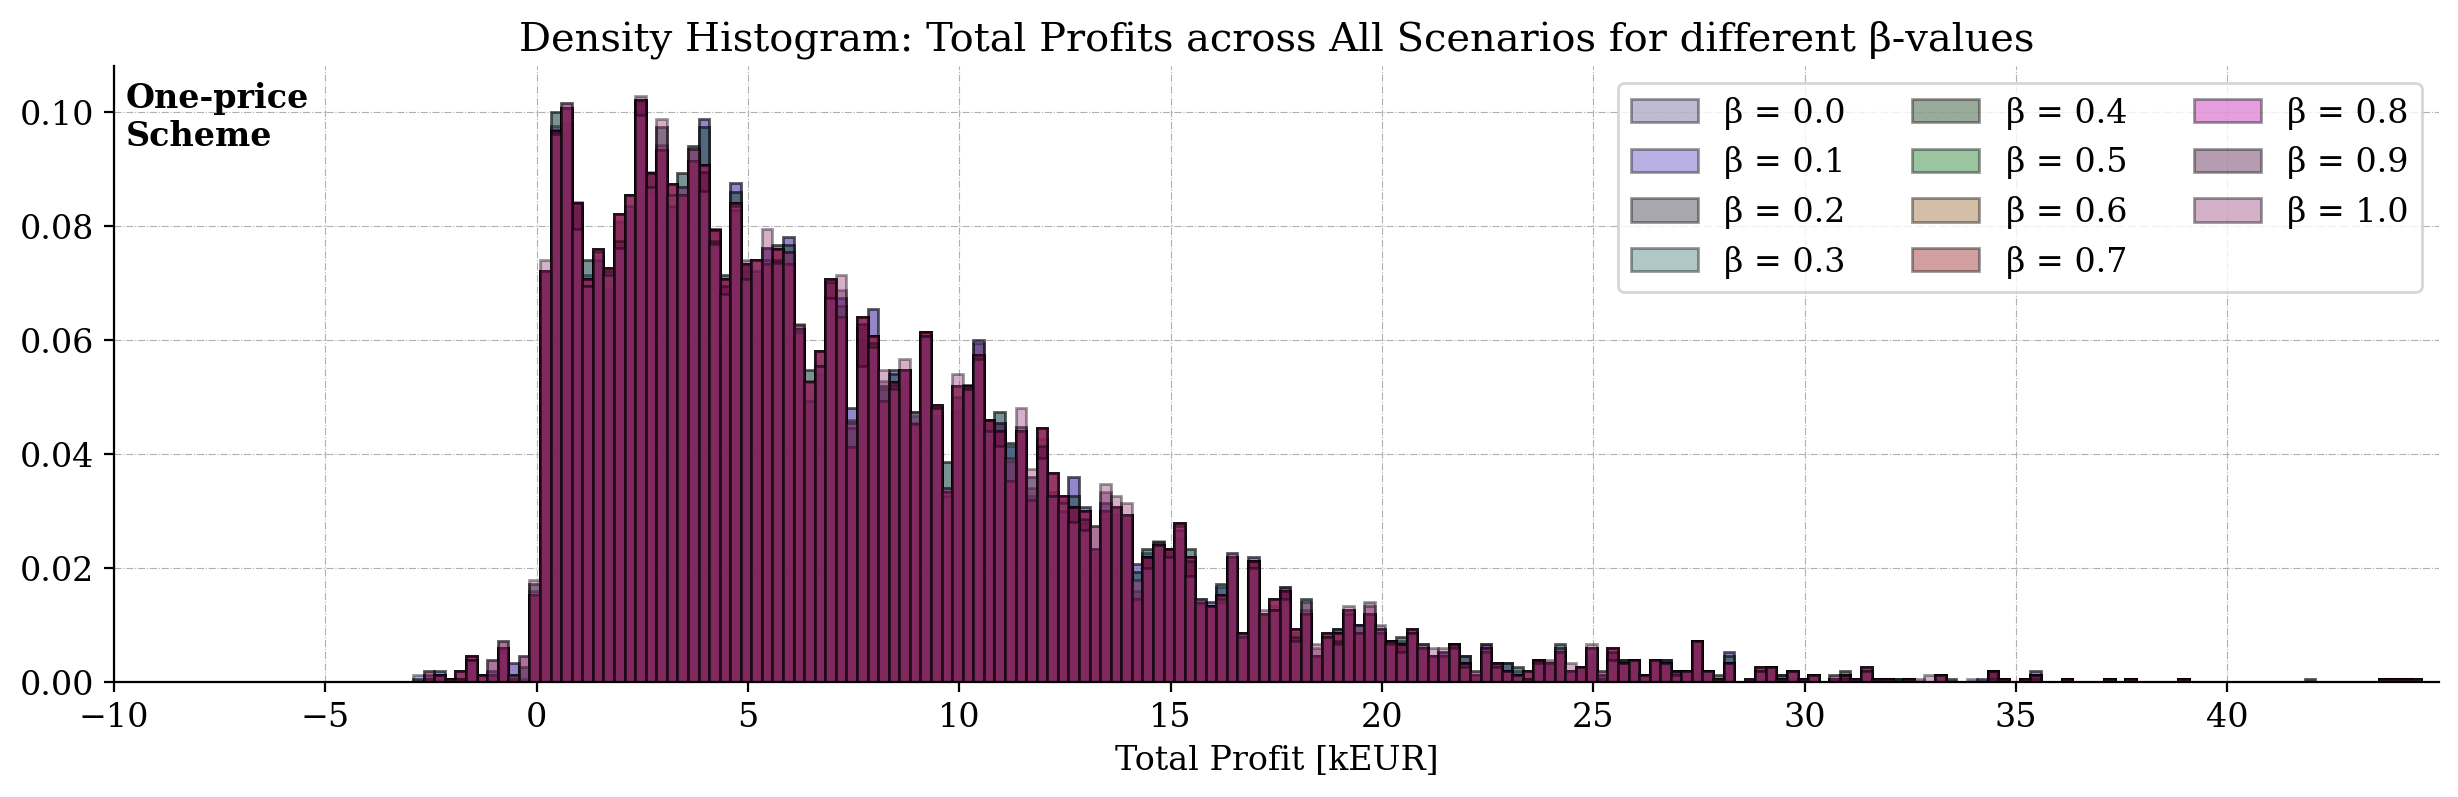

In [14]:
# Plot the probability distribution of profits for all scenarios for each beta
plt.figure(figsize=(15, 4), dpi=200)

n = 0
for beta, profits in all_scenario_profits_per_beta.items():
    plt.hist(np.array(profits) * 1e-3, bins=bins, density=True, alpha=0.4, label=f'\u03B2 = {beta.round(1)}', edgecolor='black', color=clrs[n])
    n += 1

plt.title('Density Histogram: Total Profits across All Scenarios for different \u03B2-values')
plt.xlabel('Total Profit [kEUR]')
plt.legend(ncol = 3)
plt.grid(True)
#plt.ylim(ymax=0.1425)
plt.gca().set_xticks(np.arange(-10,45,5))
plt.gca().set_xlim([-10, 45])
plt.gca().set_axisbelow(True)


plt.gca().text(0.005, 0.975, 'One-price\nScheme', transform=plt.gca().transAxes, fontsize=12, verticalalignment='top', horizontalalignment='left', color='black', weight='bold')
fig.tight_layout()
plt.savefig('Figures/Task_1C_Appendix_Profit_Distribution_V2.png', dpi=300, bbox_inches='tight')
plt.show()